In [ ]:
pip install pandas matplotlib nixtla


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from nixtla import NixtlaClient

# Initialize Nixtla client with your API key
nixtla_client = NixtlaClient(api_key="nixak-YdxgHOqWIumbzuaM3A4FiCAaIBp6NLVstE1CjJEnN2Ia9Lu0k6lttUxmz4LZtBNTNV8bYf3owJy6btvb")


In [ ]:
import numpy as np

# Generate synthetic data
np.random.seed(42)
timestamps = pd.date_range(start="2023-01-01", periods=100, freq="H")
unique_ids = ["Series_A", "Series_B", "Series_C"]
data = []

for uid in unique_ids:
    for ts in timestamps:
        value = np.random.normal(loc=50, scale=10)
        data.append([uid, ts, value])

# Create DataFrame
df = pd.DataFrame(data, columns=["unique_id", "ds", "y"])
print(df.head())

# Save for visualization
df.to_csv("synthetic_time_series.csv", index=False)


  unique_id                  ds          y
0  Series_A 2023-01-01 00:00:00  54.967142
1  Series_A 2023-01-01 01:00:00  48.617357
2  Series_A 2023-01-01 02:00:00  56.476885
3  Series_A 2023-01-01 03:00:00  65.230299
4  Series_A 2023-01-01 04:00:00  47.658466


<ipython-input-5-5b4204ac3c23>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start="2023-01-01", periods=100, freq="H")


In [ ]:
# Load synthetic data
df = pd.read_csv("synthetic_time_series.csv")
df.head()


,unique_id,ds,y
0,Series_A,2023-01-01 00:00:00,54.967142
1,Series_A,2023-01-01 01:00:00,48.617357
2,Series_A,2023-01-01 02:00:00,56.476885
3,Series_A,2023-01-01 03:00:00,65.230299
4,Series_A,2023-01-01 04:00:00,47.658466


In [ ]:
# Count the number of observations per series
counts = df.groupby('unique_id').size()
print(counts)


unique_id
Series_A    100
Series_B    100
Series_C    100
dtype: int64


In [ ]:
import numpy as np
import pandas as pd

# Function to ensure each series has at least 144 observations
def ensure_min_length(group, min_length=144):
    current_length = len(group)
    while current_length < min_length:
        last_row = group.iloc[-1]
        next_timestamp = pd.to_datetime(last_row['ds']) + pd.Timedelta(hours=1)
        new_row = {
            'unique_id': last_row['unique_id'],
            'ds': next_timestamp,
            'y': np.random.normal(loc=group['y'].mean(), scale=group['y'].std())
        }
        group = pd.concat([group, pd.DataFrame([new_row])], ignore_index=True)
        current_length += 1
    return group

# Apply the function to extend each series
padded_df = df.groupby('unique_id', group_keys=False).apply(ensure_min_length)

# Verify that all series now meet the minimum requirement
print(padded_df.groupby('unique_id').size())


unique_id
Series_A    144
Series_B    144
Series_C    144
dtype: int64


<ipython-input-15-f70cb795795b>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  padded_df = df.groupby('unique_id', group_keys=False).apply(ensure_min_length)


In [ ]:
# Reset index to avoid ambiguity
padded_df.reset_index(drop=True, inplace=True)

# Check dataset structure
print(padded_df.head())
print(padded_df.groupby('unique_id').size())


  unique_id                   ds          y
0  Series_A  2023-01-01 00:00:00  54.967142
1  Series_A  2023-01-01 01:00:00  48.617357
2  Series_A  2023-01-01 02:00:00  56.476885
3  Series_A  2023-01-01 03:00:00  65.230299
4  Series_A  2023-01-01 04:00:00  47.658466
unique_id
Series_A    144
Series_B    144
Series_C    144
dtype: int64


In [ ]:
# Perform forecasting for all series
timegpt_fcst_multiseries_df = nixtla_client.forecast(df=padded_df, h=24, level=[80, 90])

# Display the forecasted results
print(timegpt_fcst_multiseries_df.head())


  unique_id                  ds    TimeGPT  TimeGPT-hi-80  TimeGPT-hi-90  \
0  Series_A 2023-01-07 00:00:00  41.993614      48.609173      49.436115   
1  Series_A 2023-01-07 01:00:00  44.063667      46.991650      47.357647   
2  Series_A 2023-01-07 02:00:00  46.600517      53.756336      54.650814   
3  Series_A 2023-01-07 03:00:00  49.213554      59.582928      60.879097   
4  Series_A 2023-01-07 04:00:00  50.777910      53.360910      53.683784   

   TimeGPT-lo-80  TimeGPT-lo-90  
0      35.378056      34.551113  
1      41.135685      40.769688  
2      39.444700      38.550220  
3      38.844180      37.548010  
4      48.194910      47.872032  


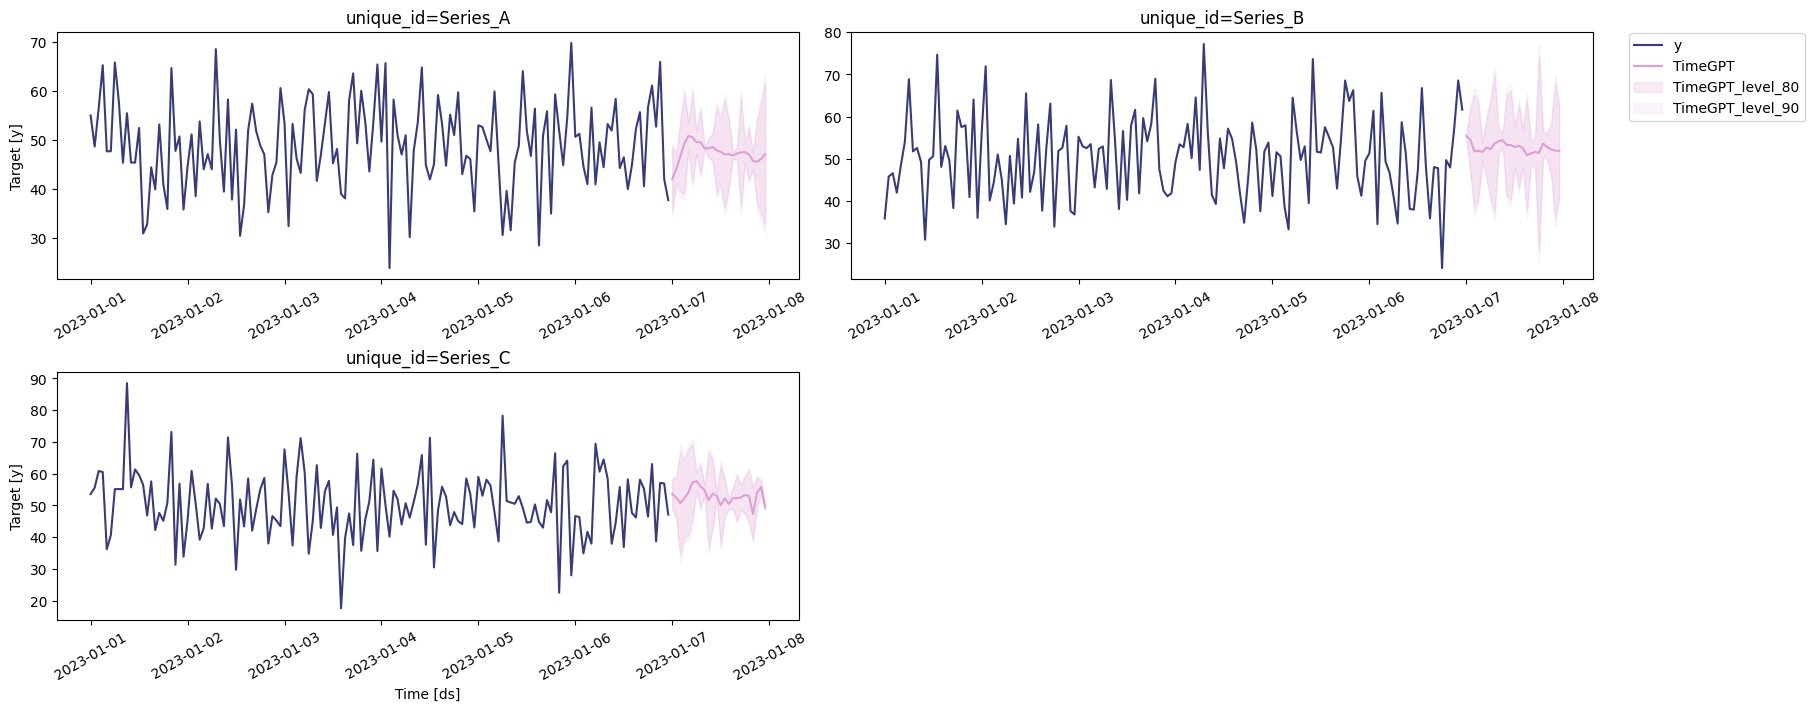

In [ ]:
nixtla_client.plot(padded_df, timegpt_fcst_multiseries_df, level=[80, 90])


In [ ]:
timegpt_fcst_multiseries_df.to_csv("forecast_results.csv", index=False)


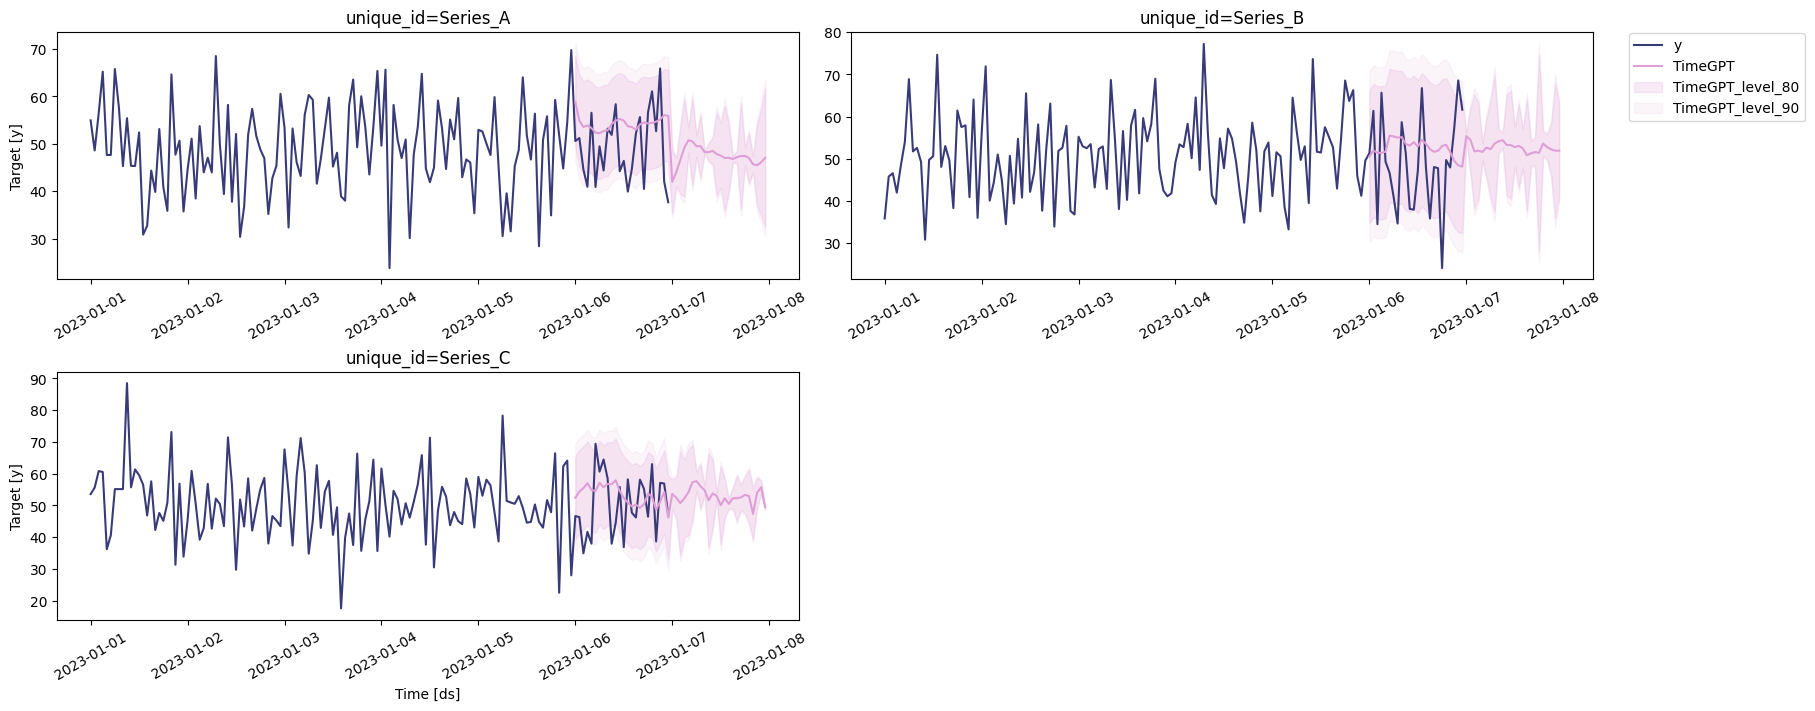

In [ ]:
# Perform forecasting with historical predictions
timegpt_fcst_with_history_df = nixtla_client.forecast(
    df=padded_df,   # Use the padded_df with sufficient observations
    h=24,           # Forecast horizon
    level=[80, 90], # Confidence intervals
    add_history=True
)

# Plot the historical forecasts with confidence intervals
nixtla_client.plot(
    padded_df,
    timegpt_fcst_with_history_df,
    level=[80, 90]
)


In [ ]:
def extend_series_to_1008(group, min_length=1008):
    current_length = len(group)
    while current_length < min_length:
        last_row = group.iloc[-1]
        next_timestamp = pd.to_datetime(last_row['ds']) + pd.Timedelta(hours=1)
        new_row = {
            'unique_id': last_row['unique_id'],
            'ds': next_timestamp,
            'y': np.random.normal(loc=group['y'].mean(), scale=group['y'].std())
        }
        group = pd.concat([group, pd.DataFrame([new_row])], ignore_index=True)
        current_length += 1
    return group

# Extend each series to at least 1008 observations
extended_df_1008 = padded_df.groupby('unique_id', group_keys=False).apply(extend_series_to_1008)
extended_df_1008.reset_index(drop=True, inplace=True)

# Verify the lengths of each series
print(extended_df_1008.groupby('unique_id').size())


unique_id
Series_A    1008
Series_B    1008
Series_C    1008
dtype: int64


<ipython-input-23-9e170b29066a>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  extended_df_1008 = padded_df.groupby('unique_id', group_keys=False).apply(extend_series_to_1008)


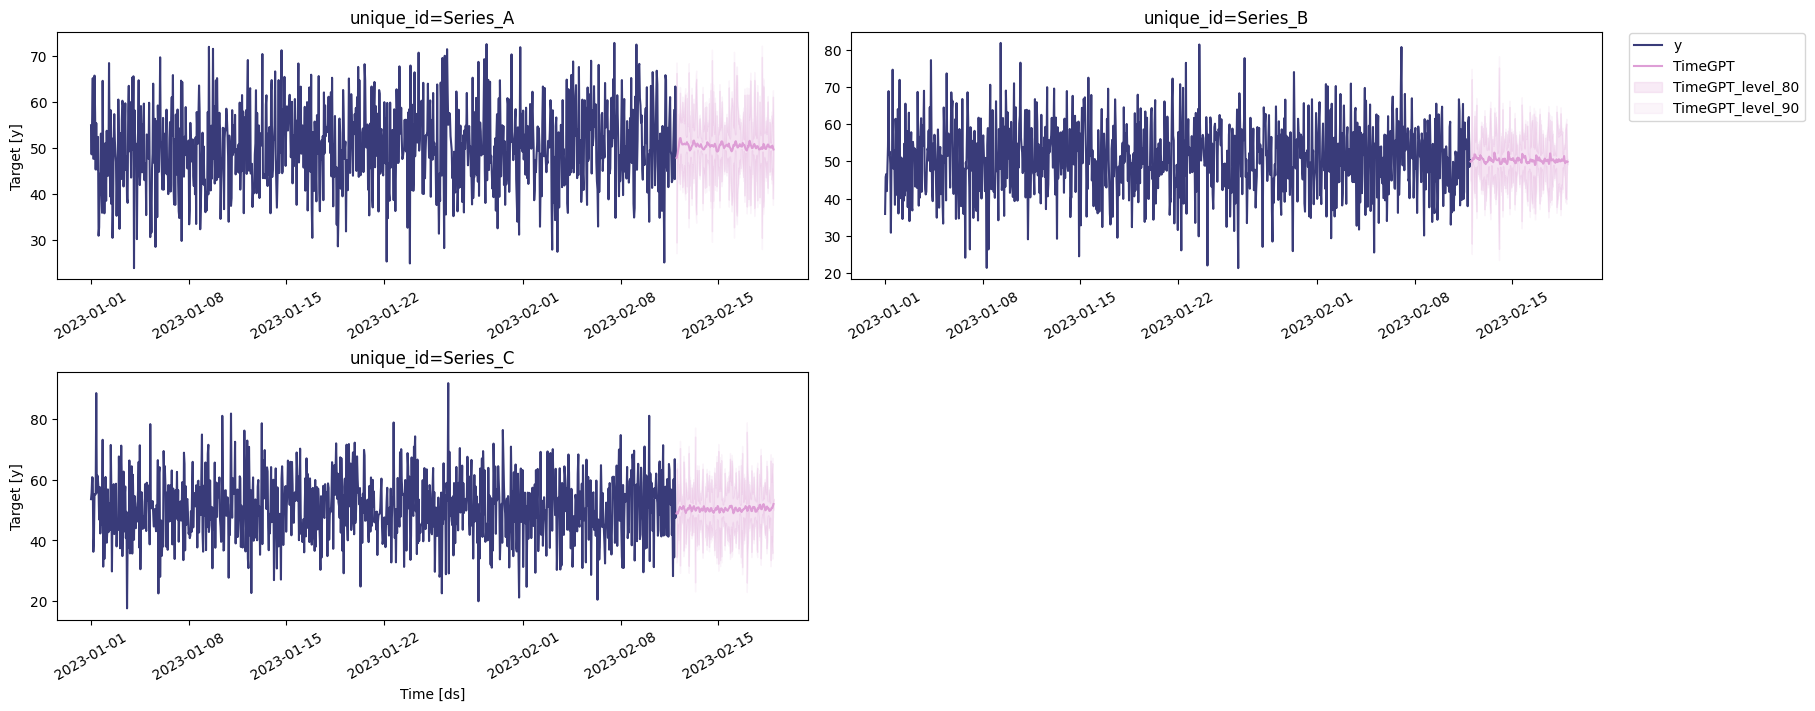

In [ ]:
long_horizon_forecast_df = nixtla_client.forecast(
    df=extended_df_1008,          # Use the extended DataFrame
    h=168,                        # Forecast horizon (7 days = 168 hours)
    model="timegpt-1-long-horizon",  # Specify the long-horizon model
    level=[80, 90]                # Confidence intervals
)

# Plot the long-horizon forecasts
nixtla_client.plot(
    extended_df_1008,
    long_horizon_forecast_df,
    level=[80, 90]
)
